In [1]:
import math
import random
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn

In [2]:
print(tf.__version__)

2.10.0


In [3]:
table = pd.read_table('./1663769555_8559356_train.txt', names=['binding','sequence'])

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
def return_binary_vectorized_form(data_frame, feat = None):
    if feat is None:
        count_vectorizer = CountVectorizer(binary=True)
    else:
        count_vectorizer = CountVectorizer(binary=True, vocabulary=feat)
    fitted_and_transformed = count_vectorizer.fit_transform(data_frame).toarray()
    return count_vectorizer,  fitted_and_transformed

In [5]:
from sklearn.feature_selection import SelectKBest, chi2
def select_k_best_features(feature_set, target_values, fraction, feature_list):
    select_bestselect_best = SelectKBest(score_func=chi2, k = int(len(feature_list)*fraction))
    select_bestselect_best.fit(feature_set,target_values)
    mask = select_bestselect_best.get_support()
    k_best_featurs = feature_list[mask]
    return k_best_featurs

In [6]:
from sklearn.model_selection import train_test_split
active_df = table.loc[table.binding == 1]
not_active_df = table.loc[table.binding == 0]
# Mainly spliting the data here for testing, that is the reason train size is set to .20
active_train, active_test, active_binding_train, active_binding_test = train_test_split(active_df.sequence, active_df.binding, shuffle=True, train_size= .80)
not_active_train, not_active_test, not_active_binding_train, not_active_binding_test = train_test_split(not_active_df.sequence, not_active_df.binding, shuffle=True, train_size=.90)

In [7]:
def createDf(data):
    pd_df = pd.DataFrame(data)
    return pd_df
def addColumn(copy_to, copy_from ,cname):
    copy_to[cname] = copy_from[cname]
    return copy_to

In [8]:
active_test_df = pd.DataFrame(active_test)
active_binding_test_df = pd.DataFrame(active_binding_test)
active_test_df['binding'] = active_binding_test_df['binding']
not_active_test_df = pd.DataFrame(not_active_test)
not_active_binding_test_df = pd.DataFrame(not_active_binding_test)
not_active_test_df['binding'] = not_active_binding_test_df['binding']
active_train_df = createDf(active_train)
active_binding_train_df = createDf(active_binding_train)
active_train_df = addColumn(active_train_df, active_binding_train_df, 'binding')
not_active_train_df = createDf(not_active_train)
not_active_binding_train_df = createDf(not_active_binding_train)
not_active_train_df = addColumn(not_active_train_df, not_active_binding_train_df, 'binding')
train_df = pd.concat([active_train_df, not_active_train_df]).reset_index()
train_df = train_df.drop('index', axis=1)
print(train_df.binding.value_counts())
test_df = pd.concat([active_test_df, not_active_test_df]).reset_index()
test_df = test_df.drop('index', axis=1)
print(test_df.binding.value_counts())
from imblearn.over_sampling import RandomOverSampler

sampler = RandomOverSampler()
x_sampled, y_sampled = sampler.fit_resample(np.array(train_df.sequence).reshape(-1, 1), train_df.binding)

0    649
1     62
Name: binding, dtype: int64
0    73
1    16
Name: binding, dtype: int64


In [9]:
final_train_set = pd.DataFrame(x_sampled, columns  =["sequence"])
final_train_set['binding'] = y_sampled
print(final_train_set.binding.value_counts())

final_test_set = pd.DataFrame(test_df.sequence, columns  =["sequence"])
final_test_set['binding'] = test_df.binding
print(final_test_set.binding.value_counts())

1    649
0    649
Name: binding, dtype: int64
0    73
1    16
Name: binding, dtype: int64


In [10]:
train_result = np.array(final_train_set.binding)
test_result = np.array(final_test_set.binding)

In [11]:
vectorizer_best, training_split = return_binary_vectorized_form(final_train_set.sequence)
test_split = vectorizer_best.transform(final_test_set.sequence).toarray()

In [12]:
print(training_split.shape)
print(test_split.shape)

(1298, 81744)
(89, 81744)


In [13]:
initial_weight = np.ones(training_split.shape[0])*(1/training_split.shape[0])

In [14]:
def updateWeight(missmatch, weight, alpha):
    mi = 0
    missmatch_size = len(missmatch)
    wi = 0

    new_weight = []
    norm_constant = 0
    while wi < len(weight):
        if mi < missmatch_size and missmatch[mi] == wi:
            k = weight[wi] * math.exp(alpha)
            mi+=1
        else:
            k = weight[wi] * math.exp(-1*alpha)
        new_weight.append( k )
        norm_constant += k
        wi += 1

    new_weight /= norm_constant
    sum =0
    for i in new_weight:
        sum+=i
    print(sum)
    # plt.plot(new_weight)
    # plt.show()
    return new_weight

In [15]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
def findMissClassificatonIndex(predicted, test_res, weight):
    error_rate = 0
    missmatch_indexes = []
    incorrect= []
    tn, fp, fn, tp = confusion_matrix(test_res, predicted).ravel()
    precision = tp / (tp+ fp)
    recall = tp / (tp+ fn)
    score = (2 * precision * recall) / (precision + recall)
    print(score)
    print(accuracy_score(test_res, predicted))
    for i, (pred, real) in enumerate(zip(predicted, test_res)):
        if pred != real:
            incorrect.append((i, pred, real))
            missmatch_indexes.append(i)
            error_rate += weight[i]
    error_rate /= len(predicted)
    # print(incorrect)
    return error_rate, missmatch_indexes

In [16]:
def rejectionSampling(train_data, train_res, weights):
    samplesize  = int(3 * len(train_data))
    new_train_data = []
    new_train_res = []
    new_weights = []
    adding_index =[]
    max_w = max(weights)

    for i in range(samplesize):
        while True:
            index = random.randrange(len(weights))
            u = max_w * random.random()
            if u <= weights[index]:
                new_train_data.append(train_data[index])
                new_train_res.append(train_res[index])
                adding_index.append(index)
                break
    # print(adding_index)
    return np.array(new_train_data), np.array(new_train_res)

In [17]:
def resample(train_data, train_res, weights):
    size = len(train_data)
    indexes = np.random.choice(int(size), int( 5 * size), replace=True, p=weights)
    new_train_data = []
    new_train_res = []
    for index in indexes:
         new_train_data.append(train_data[index])
         new_train_res.append(train_res[index])
    return np.array(new_train_data), np.array(new_train_res)

In [18]:
class EarlyStoppingMonitor(tf.keras.callbacks.Callback):
    def __init__(self):
        super(EarlyStoppingMonitor, self).__init__()
        self.f1_train = None
        self.f1_test = None
        self.count =0

    def on_epoch_end(self, epoch, logs=None):
        current_train_precision = logs.get('precision')
        current_train_recall= logs.get('recall')
        if current_train_precision==0 or current_train_recall==0:
            print("**** Waring: precision recall zero avoid exception ****")
            return
        self.f1_train = (2*current_train_precision*current_train_recall) / (current_train_precision+current_train_recall)
        if abs(self.f1_train) > .85:
            # self.count += 1
            # if self.count >4:
            self.model.stop_training = True
            print('\n\n******* Stoping on Defined Thresold *******')
            print('F1 TRAINING: ', self.f1_train)

    def on_train_end(self, logs=None):
        if self.model.stop_training:
            print("\n\n\n****** Early Stopping *******")

In [19]:
def createBaseModel():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(training_split.shape[-1],)),
        tf.keras.layers.Dense(2,activation='relu',kernel_regularizer=tf.keras.regularizers.L1(.015)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(), metrics=METRICS, optimizer='adam')

    return model

In [20]:
ensemble_size = 6
ensemble = []
alphas = []
def boosting(weights):

    for i in range(ensemble_size):
        train_data, train_res = resample(training_split, train_result, weights)
        model = createBaseModel()
        num_epochs = 50
        print( "bfore traning: ", ((sum(train_res)/len(train_res)))*100)
        model.fit(train_data, train_res,
                    epochs= num_epochs,
                    batch_size=70,
                    callbacks=[EarlyStoppingMonitor()])
        predicted_result = model.predict(training_split)
        predicted_result = [1 if i>=.5 else 0 for i in predicted_result ]
        error_rate, error_indexes = findMissClassificatonIndex(predicted_result, train_result, weights)
        print("error_rate:", error_rate)

        if error_rate > .5:
            weights = np.ones(training_split.shape[0]) * (1/training_split.shape[0])
            print("re-balancing and training because error:", error_rate)
            continue

        amount_of_say = 0.2 * ( math.log( (1-error_rate) / error_rate ) )
        alphas.append(amount_of_say)
        ensemble.append(model)
        weights = updateWeight(error_indexes, weights, amount_of_say)


In [21]:
# plt.plot(initial_weight)
boosting(initial_weight)

Metal device set to: Apple M1
bfore traning:  50.986132511556235


2022-11-09 20:21:46.501831: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-09 20:21:46.501928: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2022-11-09 20:21:48.574213: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-09 20:21:48.891647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 2s 18ms/step - loss: 1.1606 - tp: 2972.0000 - fp: 729.0000 - tn: 2452.0000 - fn: 337.0000 - precision: 0.8030 - recall: 0.8982
Epoch 2/50
91/93 [============================>.] - ETA: 0s - loss: 0.4725 - tp: 2675.0000 - fp: 91.0000 - tn: 3028.0000 - fn: 576.0000 - precision: 0.9671 - recall: 0.8228

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.8889614594898111
93/93 [==============================] - 1s 16ms/step - loss: 0.4725 - tp: 2722.0000 - fp: 93.0000 - tn: 3088.0000 - fn: 587.0000 - precision: 0.9670 - recall: 0.8226



****** Early Stopping *******
37/41 [==========================>...] - ETA: 0s

2022-11-09 20:21:52.990778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 5ms/step
0.8791946308724832
0.889060092449923
error_rate: 8.546988255013653e-05
0.9999999999999876
bfore traning:  80.20030816640985
Epoch 1/50


2022-11-09 20:21:56.964661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - ETA: 0s - loss: 1.1254 - tp: 5198.0000 - fp: 1095.0000 - tn: 190.0000 - fn: 7.0000 - precision: 0.8260 - recall: 0.9987

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.9041572656271419
93/93 [==============================] - 2s 17ms/step - loss: 1.1254 - tp: 5198.0000 - fp: 1095.0000 - tn: 190.0000 - fn: 7.0000 - precision: 0.8260 - recall: 0.9987



****** Early Stopping *******
32/41 [======================>.......] - ETA: 0s

2022-11-09 20:21:59.206796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 5ms/step
0.6694172253739041
0.5061633281972265
error_rate: 0.00012954586775641073
0.9999999999999988
bfore traning:  11.802773497688753
Epoch 1/50


2022-11-09 20:22:02.747000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 3s 22ms/step - loss: 1.1307 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 5724.0000 - fn: 766.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/50
93/93 [==============================] - 2s 20ms/step - loss: 0.4269 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 5724.0000 - fn: 766.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/50
93/93 [==============================] - 2s 19ms/step - loss: 0.4289 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 5724.0000 - fn: 766.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/50
93/93 [==============================] - 2s 20ms/step - loss: 0.4186 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 5724.0000 - fn: 766.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/50
93/93 [==============================] - 2s 20ms/step - loss: 0.4224 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 5724.0000 - fn: 766.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/50
93/93 [==============================] - 2s 20ms/s

2022-11-09 20:23:04.417910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 7ms/step
0.4014778325123153
0.6255778120184899
error_rate: 2.094674499188463e-05
0.9999999999999986
bfore traning:  70.20030816640987
Epoch 1/50


2022-11-09 20:23:08.575612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 3s 25ms/step - loss: 1.1383 - tp: 4535.0000 - fp: 1786.0000 - tn: 148.0000 - fn: 21.0000 - precision: 0.7174 - recall: 0.9954
Epoch 2/50
93/93 [==============================] - ETA: 0s - loss: 0.4263 - tp: 4516.0000 - fp: 1007.0000 - tn: 927.0000 - fn: 40.0000 - precision: 0.8177 - recall: 0.9912

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.8961206906812121
93/93 [==============================] - 2s 20ms/step - loss: 0.4263 - tp: 4516.0000 - fp: 1007.0000 - tn: 927.0000 - fn: 40.0000 - precision: 0.8177 - recall: 0.9912



****** Early Stopping *******
25/41 [=================>............] - ETA: 0s

2022-11-09 20:23:13.342042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 7ms/step
0.8240802675585285
0.7973805855161787
error_rate: 9.17781151523652e-05
1.00000000000002
bfore traning:  21.432973805855163
Epoch 1/50


2022-11-09 20:23:17.012099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 3s 22ms/step - loss: 1.1403 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 5099.0000 - fn: 1391.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/50
93/93 [==============================] - 2s 20ms/step - loss: 0.4504 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 5099.0000 - fn: 1391.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/50
93/93 [==============================] - 2s 20ms/step - loss: 0.4454 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 5099.0000 - fn: 1391.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/50
93/93 [==============================] - 2s 20ms/step - loss: 0.4455 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 5099.0000 - fn: 1391.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/50
93/93 [==============================] - 2s 22ms/step - loss: 0.4363 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 5099.0000 - fn: 1391.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/50
93/93 [==============================] - 2s 2

2022-11-09 20:23:41.208849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 7ms/step
0.18461538461538463
0.5508474576271186
error_rate: 3.296103088113218e-05
1.000000000000018
bfore traning:  79.07550077041603
Epoch 1/50


2022-11-09 20:23:45.128661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - ETA: 0s - loss: 1.1522 - tp: 5088.0000 - fp: 809.0000 - tn: 549.0000 - fn: 44.0000 - precision: 0.8628 - recall: 0.9914

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.9226584625265057
93/93 [==============================] - 3s 24ms/step - loss: 1.1522 - tp: 5088.0000 - fp: 809.0000 - tn: 549.0000 - fn: 44.0000 - precision: 0.8628 - recall: 0.9914



****** Early Stopping *******
16/41 [==========>...................] - ETA: 0s

2022-11-09 20:23:48.044912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 7ms/step
0.672538860103627
0.5130970724191063
error_rate: 0.00010014029908912117
1.0000000000000224


In [1]:
print('hello')

hello


In [22]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def repeat(test_split, test_result, start, end):
    mx = 0
    size = 0
    data = []
    f1=[]
    for i in range(start,end):
        data = some_pred(test_split, i)
        tn, fp, fn, tp = confusion_matrix(test_result, data).ravel()
        precision = tp / (tp+ fp)
        recall = tp / (tp+ fn)
        score = (2 * precision * recall) / (precision + recall)
        print(score)
        f1.append(score)
        if mx < score:
            mx = score
            size = i
        print(i)
    print(mx,size)
    return data, f1

# ensemble[0].predict()

def some_pred(test_split, esize):
    data = []
    for j in range(len(test_split)):
        pa=0
        na =0
        for i in range(esize):
            k = ensemble[i].predict([[test_split[j].reshape(1,-1)]])
            if k[0] >= .5:
                pa += alphas[i]
            else:
                na+=alphas[i]
        if pa >=na:
            data.append(1)
        else:
            data.append(0)
    # f1.append(f1_score(test_result, data, average="macro"))
    # acc.append(accuracy_score(test_result, data))
    return data

0.30476190476190473
0
1/1 [==============================] - 0s 10ms/step


2022-11-09 20:24:46.476332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 9ms/step
0.7272727272727272
1
1/1 [==============================] - 0s 13ms/step


2022-11-09 20:24:49.031617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 9ms/step
0.7272727272727272
2
1/1 [==============================] - ETA: 0s

2022-11-09 20:24:53.894377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 12ms/step
0.7272727272727272
3
1/1 [==============================] - 0s 10ms/step


2022-11-09 20:25:01.233467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 9ms/step
0.7272727272727272
4
1/1 [==============================] - 0s 8ms/step


2022-11-09 20:25:10.371493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 10ms/step
0.7272727272727272
5
0.7272727272727272 1


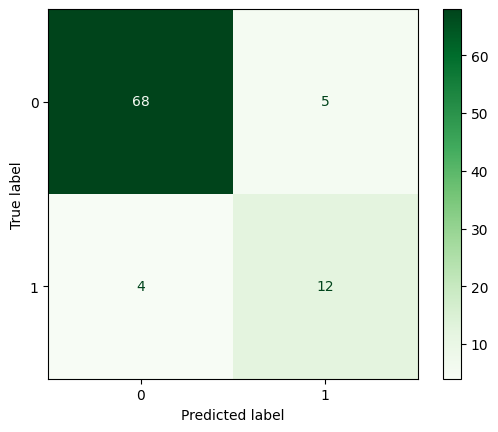

In [23]:
data, f1 = repeat(test_split,test_result,0, 6)
ConfusionMatrixDisplay.from_predictions(test_result,data,cmap='Greens')


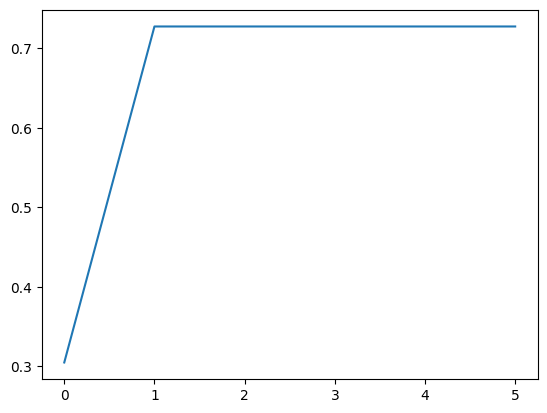

In [24]:
plt.plot(f1)

1/1 [==============================] - 0s 12ms/step


2022-11-09 20:25:47.002977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 9ms/step


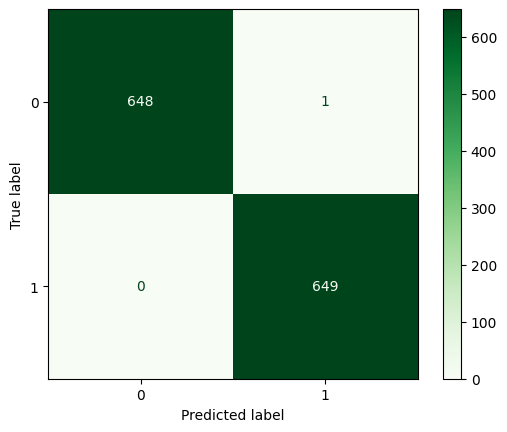

In [25]:
data =some_pred(training_split, 6)
ConfusionMatrixDisplay.from_predictions(train_result,data,cmap='Greens')
